In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, tri
import spaudiopy as spa
from pathlib import Path
import glob

In [2]:
# INPUT

# defining Parameters
N_sph = 3 # Ambisonics order
fs = 44100 #??

# input signal
file_path = '/Users/viautopia/Nextcloud/Applied Acoustics/A10p/HOA/' 

In [3]:
# loading signal 
in_path = glob.glob(file_path + '*.wav')
in_file= spa.io.load_audio(in_path, fs)
in_sig = in_file.get_signals()

in_sig = in_sig[0:(N_sph+1)**2,:]

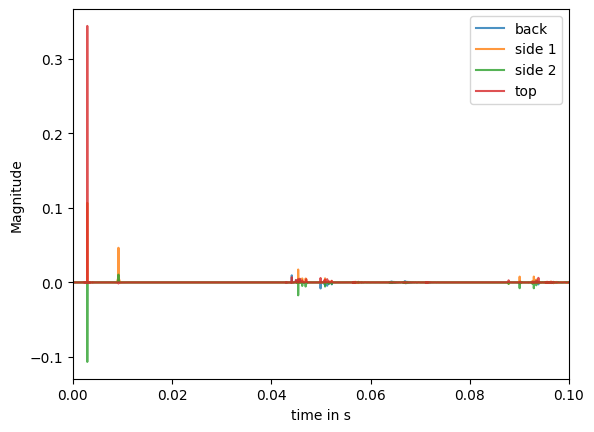

In [4]:
# defining steering directions of the beampattern
vec = np.array([[0,0,1],[1,0,0],[0,-1,0],[0,1,0],[-1,0,0],[0,0,-1]]) #top, front, left, right, back, bottom

# conversion of vec: [x,y,z] to dir: [azi, zen]
dirs = spa.utils.vec2dir(vec) 

azi_steer = dirs[:,0]
zen_steer = dirs[:,1]

w_nm = spa.parsa.sh_beamformer_from_pattern('hypercardioid', N_sph,
                                          azi_steer, zen_steer)
x_nm = in_sig
y = spa.parsa.sh_beamform(w_nm, x_nm)

t = np.arange(len(y[0,:]))/fs

#back, left, right, top
fig, ax = plt.subplots()
ax.plot(t, y[4,:], label = 'back', alpha=0.8)
ax.plot(t, y[2,:], label = 'side 1', alpha= 0.8)
ax.plot(t, y[3,:], label = 'side 2', alpha=0.8)
ax.plot(t, y[0,:], label = 'top', alpha=0.8)

plt.xlim(0,0.1)
plt.xlabel('time in s')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [5]:
# find sample with max amplitude for IR start
#max_sample = np.max(in_sig, axis= 1)
#idx_max_sample = np.argmax(in_sig, axis = 1)
#values, counts = np.unique(idx_max_sample, return_counts = True)

#ind_max_sample = values[counts.argmax()]
#IR_start = ind_max_sample

IR_start = 0

start_sample = 15e-3*fs + IR_start
duration = 100e-3*fs
end_sample = start_sample + duration

y_cutted = y[:,round(start_sample):round(end_sample)]

#back, left, right, top

top = np.sum(y_cutted[0,:])
left = np.sum(y_cutted[2,:])
right = np.sum(y_cutted[3,:])
back = np.sum(y_cutted[4,:])

In [6]:
# von Linus

# Beschreibung des Parameters

# TS - Top/Sides(left,right)

TS = 10*np.log10((top)**2/(left + right)**2)
print('TS = ' + str(TS))

# TH - Top/Horizontal(left,right,back)

TH = 10*np.log10((top)**2/(left + right + back)**2)
print('TH = ' + str(TH))

TS = 18.16643497909508
TH = 19.38641837687364


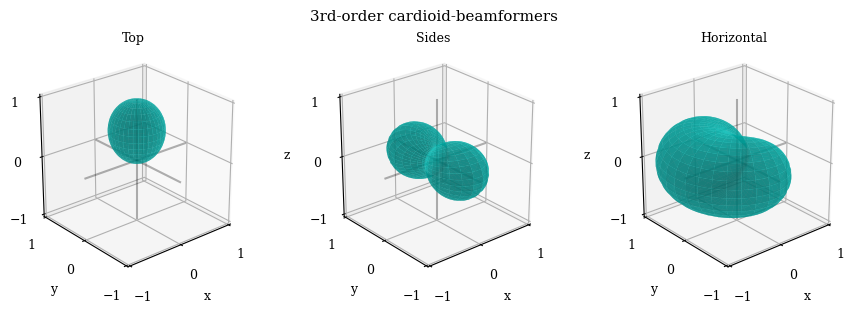

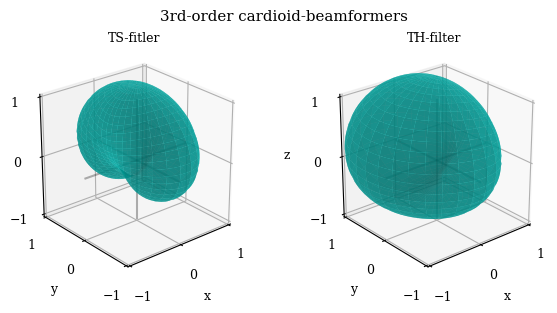

In [7]:
# Publication stuff
default_figsize = (3.39, 3.0)
plt.rcParams['figure.figsize'] = default_figsize
font = {'family' : 'serif',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['axes.titlesize'] = 9

N_sph = 3
shtype = 'real'

ENREC = True  # amplitude or energy reconstruction
pattern = "cardioid"

#steering direction
vec_s = np.array([[0,-1,0],[0,1,0]]) #sides
vec_b = np.array([-1,0,0]) #back
vec_t = np.array([0,0,1]) #top


# conversion of vec: [x,y,z] to dir: [azi, zen]
dirs_s = spa.utils.vec2dir(vec_s)
dirs_b = spa.utils.vec2dir(vec_b)  
dirs_t = spa.utils.vec2dir(vec_t) 

azi_steer_s = dirs_s[:,0]
zen_steer_s = dirs_s[:,1]

azi_steer_t = dirs_t[0]
zen_steer_t = dirs_t[1]

azi_steer_b = dirs_b[0]
zen_steer_b = dirs_b[1]

# plot of Beamformer
w_nm_t = spa.parsa.sh_beamformer_from_pattern(pattern, N_sph,
                                            azi_steer_t, zen_steer_t)

w_nm_s = spa.parsa.sh_beamformer_from_pattern(pattern, N_sph,
                                            azi_steer_s, zen_steer_s)

w_nm_b = spa.parsa.sh_beamformer_from_pattern(pattern, N_sph,
                                            azi_steer_b, zen_steer_b)


# plot for TS/TH-filter
fig = spa.plot.sh_coeffs_subplot([w_nm_t, w_nm_s[0,:]+w_nm_s[1,:], w_nm_s[0,:]+w_nm_s[1,:]+w_nm_b], titles=["Top", "Sides",  "Horizontal"], cbar=False, title = '3rd-order cardioid-beamformers')

# plot for TS/TH-filter
fig = spa.plot.sh_coeffs_subplot([w_nm_s[0,:]+w_nm_s[1,:]+w_nm_t, w_nm_s[0,:]+w_nm_s[1,:]+w_nm_b+w_nm_t], titles=["TS-fitler", "TH-filter"], cbar=False, title = '3rd-order cardioid-beamformers')

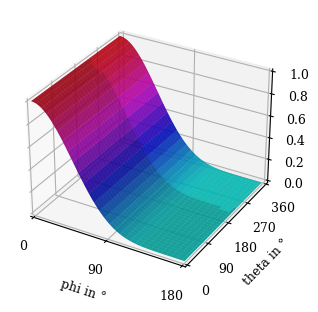

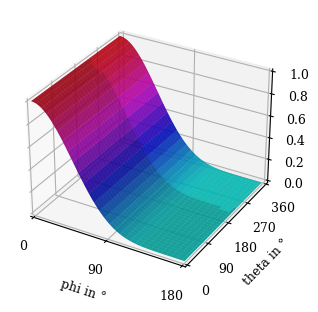

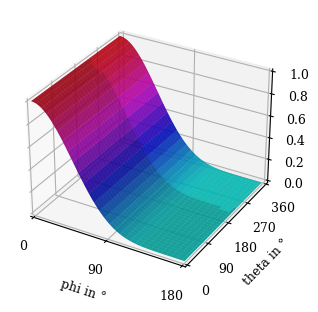

In [47]:
# filter plot
plot_filter(w_nm_t)
w_nm_s12 = w_nm_s[0,:]+w_nm_s[1,:]
plot_filter(w_nm_s12)
w_nm_h=w_nm_s[0,:]+w_nm_s[1,:]+w_nm_b
plot_filter(w_nm_h)

def plot_filter(F_nm, sh_type=None, azi_steps=5, el_steps=3, title=None,
              ax=None):

    F_nm = spa.utils.asarray_1d(F_nm)
    F_nm = F_nm[:, np.newaxis]

    sh_type = 'complex' if np.iscomplexobj(F_nm) else 'real'

    phi_plot, theta_plot = np.meshgrid(np.linspace(0, np.pi,
                                        int(360 / azi_steps)),
                            np.linspace(10e-8, np.pi - 10e-8,
                                        int(180 / el_steps)))

    f_plot = spa.sph.inverse_sht(w_nm_t, phi_plot.ravel(), theta_plot.ravel(),
                    sh_type)
    f_r = np.abs(f_plot)


    fig = plt.figure(constrained_layout=True)
    ax = fig.add_subplot(projection='3d')

    m = cm.ScalarMappable(cmap=cm.hsv,
                norm=colors.Normalize(vmin=-1, vmax=1))
    m.set_array(f_r)
    c = m.to_rgba(f_r.reshape(phi_plot.shape))

    ax.plot_surface(spa.utils.rad2deg(theta_plot), spa.utils.rad2deg(phi_plot),
        f_r.reshape(phi_plot.shape),
        facecolors=c,
        edgecolor='none', linewidth=0.06, alpha=0.68, shade=True)

    ax.set_xlim(0,180)
    ax.set_ylim(0,360)
    ax.set_zlim(0,1)

    ax.set_xticks([0,90,180])
    ax.set_yticks([0,90,180,270,360])

    ax.set_xlabel('phi in °')
    ax.set_ylabel('theta in °')
    ax.set_zlabel('S')

    plt.grid(True)

In [46]:
F_nm = w_nm_s12
F_nm = spa.utils.asarray_1d(F_nm)
F_nm = F_nm[:, np.newaxis]

azi_steps=5
el_steps=3

sh_type = 'complex' if np.iscomplexobj(F_nm) else 'real'

phi_plot, theta_plot = np.meshgrid(np.linspace(-np.pi, np.pi,
                                    int(360 / azi_steps)),
                        np.linspace(10e-8, np.pi - 10e-8,
                                    int(180 / el_steps)))

f_plot = spa.sph.inverse_sht(w_nm_t, phi_plot.ravel(), theta_plot.ravel(),
                sh_type, N_sph=3)
f_r = np.abs(f_plot)
f_angle = np.angle(f_plot)

print(f_plot)

[[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 ...
 [3.66500689e-17]
 [3.66500689e-17]
 [3.66500689e-17]]


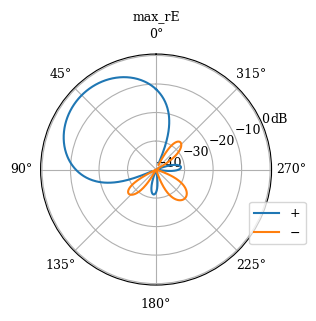

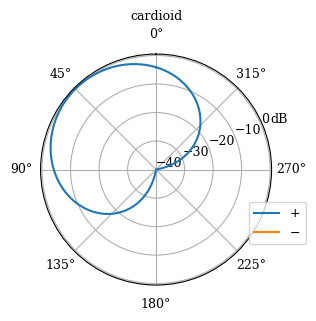

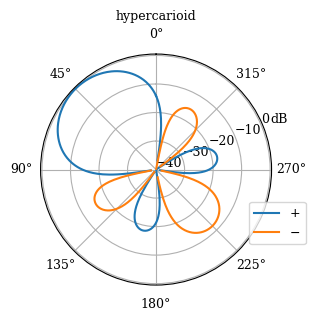

In [10]:
# defining dirac
dirac_azi = np.deg2rad(45)
dirac_zen = np.deg2rad(45)

azi = np.linspace(0, 2 * np.pi, 720, endpoint=True)

# Bandlimited Dirac pulse, with max r_E tapering window

w_n = spa.sph.max_rE_weights(N_sph)
#w_n = spa.sph.unity_gain(w_n)
dirac_tapered = spa.sph.bandlimited_dirac(N_sph, azi - dirac_azi, w_n=w_n)

spa.plot.polar(azi, dirac_tapered, title = "max_rE")

w_n = spa.sph.cardioid_modal_weights(N_sph)
#w_n = spa.sph.unity_gain(w_n)
dirac_tapered = spa.sph.bandlimited_dirac(N_sph, azi - dirac_azi, w_n=w_n)

spa.plot.polar(azi, dirac_tapered, title = "cardioid")

w_n = spa.sph.hypercardioid_modal_weights(N_sph)
#w_n = spa.sph.unity_gain(w_n)
dirac_tapered = spa.sph.bandlimited_dirac(N_sph, azi - dirac_azi, w_n=w_n)

spa.plot.polar(azi, dirac_tapered, title = "hypercarioid")